<a href="https://colab.research.google.com/github/gopal2812/mlblr/blob/master/GloVe_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
import gensim.downloader as api
glove_model = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [3]:
glove_model["beautiful"]

array([-2.3852e-01, -3.3704e-01, -2.6531e-01, -3.4693e-01, -1.2875e-01,
        1.0698e-01, -2.4669e-02,  2.6829e-02, -1.0024e-01, -9.1494e-01,
        4.8989e-01, -1.0362e-01, -2.4535e-01,  5.7003e-01, -3.5189e-02,
       -3.7690e-01, -6.9177e-02, -2.5942e-01,  2.2511e-01,  5.1855e-01,
       -3.9326e-01,  1.2665e+00, -4.4396e-01,  7.6827e-01, -1.0909e-02,
       -2.4237e-01, -1.0275e-01, -4.9712e-01, -8.0183e-02,  4.0611e-01,
        2.1275e-01,  6.5182e-01, -1.1487e+00,  4.6080e-03, -6.8265e-01,
        9.6941e-01, -7.6194e-02, -4.1590e-01, -2.7069e-01, -5.3364e-02,
       -7.9631e-02, -2.6670e-01, -2.1544e-02,  2.2392e-01,  5.5741e-02,
        8.4611e-02,  8.6011e-01,  4.8927e-01,  4.7428e-01, -2.4446e-01,
       -2.1553e-01,  1.4370e-01,  5.0683e-01, -5.8435e-01, -5.6243e-01,
       -6.3757e-02, -2.2861e-01, -6.9374e-02,  5.6618e-01, -8.7813e-02,
       -2.1272e-01, -1.6319e-01,  3.3545e-01,  1.3707e-01, -1.1920e-03,
        9.7461e-02,  3.2382e-01, -2.2693e-01, -1.7767e-01,  4.01

In [4]:
!wget http://mattmahoney.net/dc/text8.zip

--2021-02-06 04:43:58--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  3.84MB/s    in 7.8s    

2021-02-06 04:44:05 (3.81 MB/s) - ‘text8.zip’ saved [31344016/31344016]



Hallo leute! Today’s post we will implement the awesome model to learn word embeddings Glove: Global Vectors for Word Representation, using Pytorch. Developed by Stanford, the main idea is to leverage the matrix of word cooccurrences in order to extract “dimensions of meaning”, outputing word vectors that naturally captures word semantics and thus being useful representations in a lot of tasks, such word analogies. You can find more information in the original paper here .

For this project, we will use the text8 dataset (that can be download here). This dataset is a dump of cleaned wikipedia texts. More details here .

First, we just import the necessary libs.

In [5]:
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE

Next we will create a dataset class to manage our feature extraction and batch generation. We must create a cooccurence matrix for every word to feed the glove model. We will generate a vocab of ~190k words. If we create a common matrix, it would have 190000² entries, which would result in ~36 billion entries. If we consider each value a 32bit integer, we are talking of ~135GB of memory, too much to store and process. To handle this issue we can leverage the fact that most of the entries of this matrix are 0 so we just need to store the non-zero values, which drastically reduce the amount of memory necessary.

In [6]:
class GloveDataset:

  def __init__(self, text, n_words=200000, window_size=5):
      self._window_size = window_size
      self._tokens = text.split(" ")[:n_words]
      word_counter = Counter()
      word_counter.update(self._tokens)
      self._word2id = {w:i for i, (w,_) in enumerate(word_counter.most_common())}
      self._id2word = {i:w for w, i in self._word2id.items()}
      self._vocab_len = len(self._word2id)

      self._id_tokens = [self._word2id[w] for w in self._tokens]

      self._create_coocurrence_matrix()

      print("# of words: {}".format(len(self._tokens)))
      print("Vocabulary length: {}".format(self._vocab_len))

  def _create_coocurrence_matrix(self):
      cooc_mat = defaultdict(Counter)
      for i, w in enumerate(self._id_tokens):
          start_i = max(i - self._window_size, 0)
          end_i = min(i + self._window_size + 1, len(self._id_tokens))
          for j in range(start_i, end_i):
              if i != j:
                  c = self._id_tokens[j]
                  cooc_mat[w][c] += 1 / abs(j-i)

      self._i_idx = list()
      self._j_idx = list()
      self._xij = list()

      #Create indexes and x values tensors
      for w, cnt in cooc_mat.items():
          for c, v in cnt.items():
              self._i_idx.append(w)
              self._j_idx.append(c)
              self._xij.append(v)

      self._i_idx = torch.LongTensor(self._i_idx).cuda()
      self._j_idx = torch.LongTensor(self._j_idx).cuda()
      self._xij = torch.FloatTensor(self._xij).cuda()


  def get_batches(self, batch_size):
      #Generate random idx
      rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))

      for p in range(0, len(rand_ids), batch_size):
          batch_ids = rand_ids[p:p+batch_size]
          yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]
!unzip text8.zip
dataset = GloveDataset(open("/content/text8").read(), 10000000)

Archive:  text8.zip
  inflating: text8                   
# of words: 10000000
Vocabulary length: 189075


Here we create the class of our glove model. In its forward pass it will perform the yellow part of the Glove loss function, described in the original paper:

![](https://cdn.hashnode.com/res/hashnode/image/upload/v1587152473299/6HedPZypj.png?auto=compress)


In [7]:
EMBED_DIM = 300
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        return x
glove = GloveModel(dataset._vocab_len, EMBED_DIM)
glove.cuda()


GloveModel(
  (wi): Embedding(189075, 300)
  (wj): Embedding(189075, 300)
  (bi): Embedding(189075, 1)
  (bj): Embedding(189075, 1)
)

We must define a function to compute the weighting term f(Xij) of the loss function as per described in the paper:


![](https://cdn.hashnode.com/res/hashnode/image/upload/v1587152743199/bjCyXW0Wc.png?auto=compress)


In [8]:
def weight_func(x, x_max, alpha):
    wx = (x/x_max)**alpha
    wx = torch.min(wx, torch.ones_like(wx))
    return wx.cuda()


The loss function described in the Glove paper is a weighted mean squared error. Pytorch 1.0 doesn’t have implementation for it, so we must write it ourselves. A good practice is to reuse any piece of this function already implemented so we take advantage of any optimization it might have:

In [9]:
def wmse_loss(weights, inputs, targets):
    loss = weights * F.mse_loss(inputs, targets, reduction='none')
    return torch.mean(loss).cuda()


Although we are using a diferent configuration (like the dataset) of the original paper, we will use the same optimizer and learning rate it describes.

In [10]:
optimizer = optim.Adagrad(glove.parameters(), lr=0.05)


Now we can write our training loop. The ALPHA and X_MAX parameters are set accoring to the paper. We also save our model states every 100 epochs.

In [11]:
N_EPOCHS = 10
BATCH_SIZE = 2048
X_MAX = 100
ALPHA = 0.75
n_batches = int(len(dataset._xij) / BATCH_SIZE)
loss_values = list()
for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij, i_idx, j_idx in dataset.get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx, j_idx)
        weights_x = weight_func(x_ij, X_MAX, ALPHA)
        loss = wmse_loss(weights_x, outputs, torch.log(x_ij))

        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

        if batch_i % 100 == 0:
            print("Epoch: {}/{} \t Batch: {}/{} \t Loss: {}".format(e, N_EPOCHS, batch_i, n_batches, np.mean(loss_values[-20:])))  

    print("Saving model...")
    torch.save(glove.state_dict(), "text8.pt")


Epoch: 1/10 	 Batch: 100/10726 	 Loss: 1.1348604142665863
Epoch: 1/10 	 Batch: 200/10726 	 Loss: 1.0804851442575454
Epoch: 1/10 	 Batch: 300/10726 	 Loss: 1.0364858001470565
Epoch: 1/10 	 Batch: 400/10726 	 Loss: 0.9997769653797149
Epoch: 1/10 	 Batch: 500/10726 	 Loss: 0.9446597218513488
Epoch: 1/10 	 Batch: 600/10726 	 Loss: 0.949299019575119
Epoch: 1/10 	 Batch: 700/10726 	 Loss: 0.8937464535236359
Epoch: 1/10 	 Batch: 800/10726 	 Loss: 0.9205620467662812
Epoch: 1/10 	 Batch: 900/10726 	 Loss: 0.8463428169488907
Epoch: 1/10 	 Batch: 1000/10726 	 Loss: 0.8381368011236191
Epoch: 1/10 	 Batch: 1100/10726 	 Loss: 0.8281329065561295
Epoch: 1/10 	 Batch: 1200/10726 	 Loss: 0.8248848795890809
Epoch: 1/10 	 Batch: 1300/10726 	 Loss: 0.7925777703523635
Epoch: 1/10 	 Batch: 1400/10726 	 Loss: 0.7858383536338807
Epoch: 1/10 	 Batch: 1500/10726 	 Loss: 0.7826431781053543
Epoch: 1/10 	 Batch: 1600/10726 	 Loss: 0.7609578937292099
Epoch: 1/10 	 Batch: 1700/10726 	 Loss: 0.7739126831293106
Epoch: 

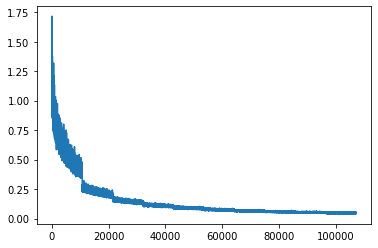

In [12]:
plt.plot(loss_values)

Here we sum over the two embedding matrices (as per recommendation of the original paper) to improve results. We then plot the TSNE space of the top 300 words to validate our word embeddings.

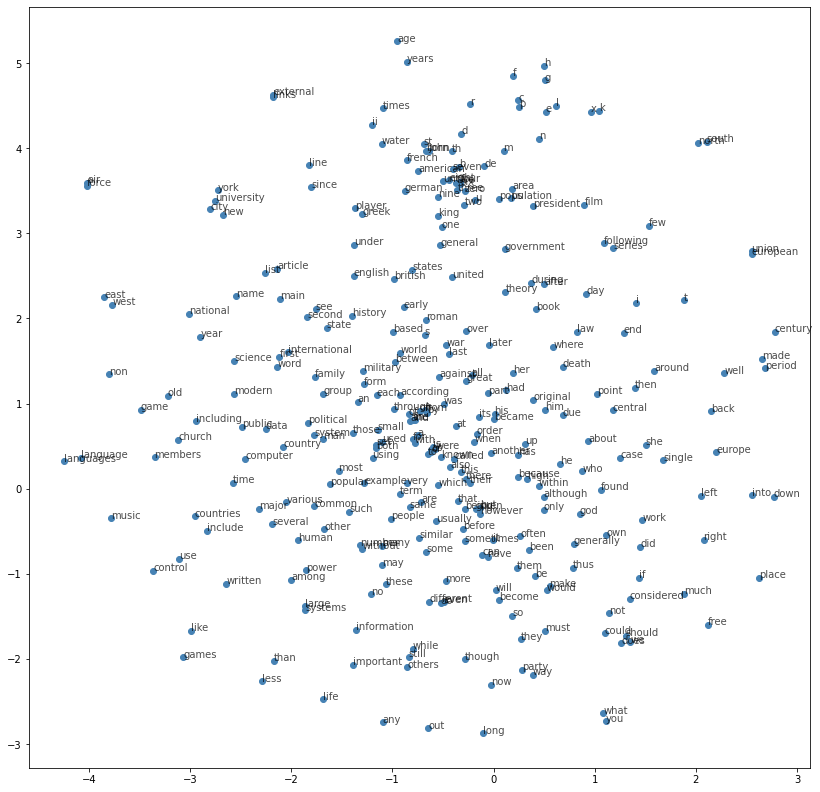

In [13]:
emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = emb_i + emb_j
top_k = 300
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[:top_k, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(dataset._id2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)


Checking the words that are close, we can say that our model performs pretty good! We can check that it clusters the direction words north, south, west, east and even central. It also clusters together words with their plural form like system/systems and language/languages.